In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def plot_series(time, series, format = '-', start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def trend(time, slope = 0):
    return slope * time

def seasonality(time, period, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype = 'float32')
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period = 365, amplitude = amplitude)

series += noise(time, noise_level = noise_level, seed = 42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer_size).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size = 128, shuffle_buffer_size = shuffle_buffer_size)
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
    tf.keras.layers.SimpleRNN(40, return_sequences = True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** ( epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)
model.compile(optimizer = optimizer, loss = tf.keras.losses.Huber(), metrics = ['mae'])

model.summary()
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 10ms/step - loss: 195.5726 - mae: 196.0726 - lr: 1.0000e-08
Epoch 

8/8 [==============================] - 0s 9ms/step - loss: 8.3989 - mae: 8.8876 - lr: 1.5849e-05
Epoch 66/100
8/8 [==============================] - 0s 9ms/step - loss: 7.0912 - mae: 7.5794 - lr: 1.7783e-05
Epoch 67/100
8/8 [==============================] - 0s 9ms/step - loss: 6.5099 - mae: 6.9899 - lr: 1.9953e-05
Epoch 68/100
8/8 [==============================] - 0s 9ms/step - loss: 7.7735 - mae: 8.2593 - lr: 2.2387e-05
Epoch 69/100
8/8 [==============================] - 0s 9ms/step - loss: 6.7757 - mae: 7.2568 - lr: 2.5119e-05
Epoch 70/100
8/8 [==============================] - 0s 9ms/step - loss: 6.5602 - mae: 7.0438 - lr: 2.8184e-05
Epoch 71/100
8/8 [==============================] - 0s 9ms/step - loss: 7.9277 - mae: 8.4153 - lr: 3.1623e-05
Epoch 72/100
8/8 [==============================] - 0s 9ms/step - loss: 13.5085 - mae: 14.0023 - lr: 3.5481e-05
Epoch 73/100
8/8 [==============================] - 0s 9ms/step - loss: 14.8995 - mae: 15.3932 - lr: 3.9811e-05
Epoch 74/100
8/8 [=

(1e-08, 0.0001, 0.0, 30.0)

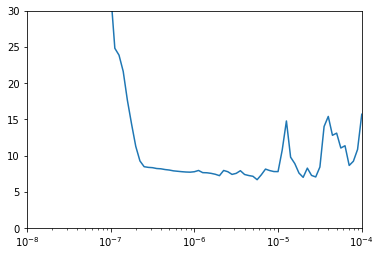

In [6]:
plt.semilogx(history.history['lr'], history.history['mae'])
plt.axis([1e-8, 1e-4, 0, 30])

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer_size = shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 9ms/step - loss: 81.7535 - mae: 82.2534
Epoch 2/400
8/8 [==============================] - 0s 9ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 9ms/step - loss: 15.9200 - mae: 16.4143
Epoch 4/400
8/8 [==============================] - 0s 9ms/step - loss: 12.2877 - mae: 12.7811
Epoch 5/400
8/8 [==============================] - 0s 9ms/step - loss: 10.1474 - mae: 10.6375
Epoch 6/400
8/8 [==============================] - 0s 9ms/step - loss: 16.6683 - mae: 17.1623
Epoch 7/400
8/8 [==============================] - 0s 9ms/step - loss: 13.3352 - mae: 13.8275
Epoch 8/400
8/8 [==============================] - 0s 9ms/step - loss: 10.8014 - mae: 11.2916
Epoch 9/400
8/8 [==============================] - 0s 9ms/step - loss: 9.5007 - mae: 9.9901
Epoch 10/400
8/8 [==============================] - 0s 9ms/step - loss: 8.7426 - mae: 9.2330
Epoch 11/400
8/8 [==============================] - 0s 9ms/step

8/8 [==============================] - 0s 9ms/step - loss: 7.0029 - mae: 7.4900
Epoch 89/400
8/8 [==============================] - 0s 9ms/step - loss: 6.2240 - mae: 6.7092
Epoch 90/400
8/8 [==============================] - 0s 9ms/step - loss: 8.1883 - mae: 8.6749
Epoch 91/400
8/8 [==============================] - 0s 9ms/step - loss: 5.9514 - mae: 6.4350
Epoch 92/400
8/8 [==============================] - 0s 9ms/step - loss: 5.8155 - mae: 6.2939
Epoch 93/400
8/8 [==============================] - 0s 9ms/step - loss: 4.9436 - mae: 5.4242
Epoch 94/400
8/8 [==============================] - 0s 9ms/step - loss: 4.7582 - mae: 5.2375
Epoch 95/400
8/8 [==============================] - 0s 9ms/step - loss: 4.6642 - mae: 5.1432
Epoch 96/400
8/8 [==============================] - 0s 9ms/step - loss: 5.9613 - mae: 6.4431
Epoch 97/400
8/8 [==============================] - 0s 9ms/step - loss: 5.3446 - mae: 5.8273
Epoch 98/400
8/8 [==============================] - 0s 9ms/step - loss: 4.6516 - ma

8/8 [==============================] - 0s 9ms/step - loss: 5.0884 - mae: 5.5712
Epoch 176/400
8/8 [==============================] - 0s 9ms/step - loss: 4.9050 - mae: 5.3856
Epoch 177/400
8/8 [==============================] - 0s 9ms/step - loss: 4.5179 - mae: 4.9957
Epoch 178/400
8/8 [==============================] - 0s 9ms/step - loss: 5.0667 - mae: 5.5452
Epoch 179/400
8/8 [==============================] - 0s 9ms/step - loss: 4.9477 - mae: 5.4251
Epoch 180/400
8/8 [==============================] - 0s 9ms/step - loss: 5.0318 - mae: 5.5135
Epoch 181/400
8/8 [==============================] - 0s 9ms/step - loss: 4.2272 - mae: 4.7029
Epoch 182/400
8/8 [==============================] - 0s 9ms/step - loss: 4.7941 - mae: 5.2729
Epoch 183/400
8/8 [==============================] - 0s 9ms/step - loss: 4.6984 - mae: 5.1779
Epoch 184/400
8/8 [==============================] - 0s 9ms/step - loss: 5.2723 - mae: 5.7573
Epoch 185/400
8/8 [==============================] - 0s 9ms/step - loss: 7

8/8 [==============================] - 0s 9ms/step - loss: 5.4516 - mae: 5.9350
Epoch 263/400
8/8 [==============================] - 0s 9ms/step - loss: 4.7289 - mae: 5.2076
Epoch 264/400
8/8 [==============================] - 0s 9ms/step - loss: 4.4283 - mae: 4.9071
Epoch 265/400
8/8 [==============================] - 0s 9ms/step - loss: 4.8590 - mae: 5.3403
Epoch 266/400
8/8 [==============================] - 0s 9ms/step - loss: 4.4015 - mae: 4.8746
Epoch 267/400
8/8 [==============================] - 0s 9ms/step - loss: 4.1528 - mae: 4.6261
Epoch 268/400
8/8 [==============================] - 0s 9ms/step - loss: 4.4519 - mae: 4.9268
Epoch 269/400
8/8 [==============================] - 0s 9ms/step - loss: 4.2816 - mae: 4.7548
Epoch 270/400
8/8 [==============================] - 0s 9ms/step - loss: 4.2412 - mae: 4.7126
Epoch 271/400
8/8 [==============================] - 0s 9ms/step - loss: 4.8782 - mae: 5.3551
Epoch 272/400
8/8 [==============================] - 0s 9ms/step - loss: 5

8/8 [==============================] - 0s 9ms/step - loss: 5.7351 - mae: 6.2172
Epoch 350/400
8/8 [==============================] - 0s 9ms/step - loss: 4.8550 - mae: 5.3369
Epoch 351/400
8/8 [==============================] - 0s 9ms/step - loss: 5.0608 - mae: 5.5417
Epoch 352/400
8/8 [==============================] - 0s 9ms/step - loss: 5.9287 - mae: 6.4063
Epoch 353/400
8/8 [==============================] - 0s 9ms/step - loss: 6.5430 - mae: 7.0317
Epoch 354/400
8/8 [==============================] - 0s 9ms/step - loss: 5.7728 - mae: 6.2551
Epoch 355/400
8/8 [==============================] - 0s 9ms/step - loss: 7.0278 - mae: 7.5138
Epoch 356/400
8/8 [==============================] - 0s 9ms/step - loss: 6.2289 - mae: 6.7119
Epoch 357/400
8/8 [==============================] - 0s 9ms/step - loss: 5.1377 - mae: 5.6137
Epoch 358/400
8/8 [==============================] - 0s 9ms/step - loss: 4.6555 - mae: 5.1339
Epoch 359/400
8/8 [==============================] - 0s 10ms/step - loss: 

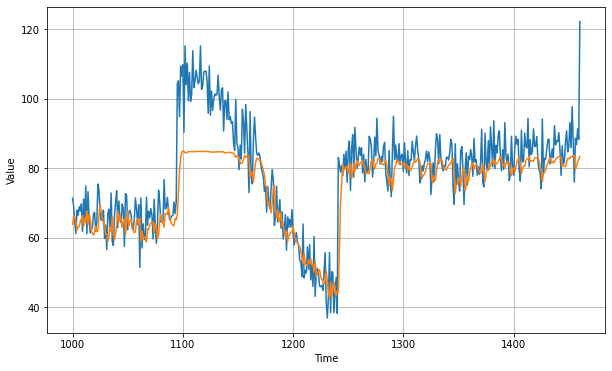

In [8]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [9]:
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

6.5572386


<Figure size 432x288 with 0 Axes>

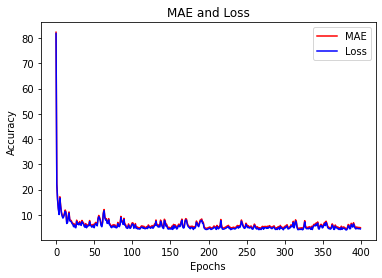

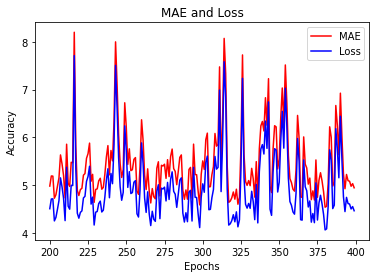

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()